In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('gdrive/My Drive/LetsMD/Colab Notebooks/repayment/')

In [ ]:
import os
import copy
import datetime
import warnings

import random
from datetime import datetime
import re

import numpy as np
from scipy.stats import t
import pandas as pd
import keras

from matplotlib import pyplot as plt
import matplotlib as mpl

from wordcloud import WordCloud

import seaborn as sns

In [ ]:
raw_data_1 = pd.read_csv("default_fields_1.csv")
raw_data_2 = pd.read_csv("default_additional_fields.csv")
pincodes = pd.read_csv("all_pincodes.csv", encoding='ISO-8859-1')

In [ ]:
data = pd.merge(raw_data_1, raw_data_2, on = 'lead_id')
data['address_city'] = data['c_address_pincode'].map(pincodes.set_index('Pincode')['City'])
data.set_index('lead_id', inplace = True)
pd.set_option('display.max_columns',100)
data.head()

,bucket,sales,submitted_by,dmi_credit_decision,dmi_cibil_score,followup,assigned_to,lender,exit_status,patient_categories,lead_account,dmi_experian_score,type,loan_amount,loan_tenure,loan_rate,subvention_percentage,processing_fee,down_payment,net_disbursal_amount,loan_purpose,loan_to_be_disbursed,proposed_emi,advance_emi,surgery,surgery_id,hospital,hospital_id,hospital_location,subvention_product_id,referrer,referrer_name,r1_name,r1_phone,r1_mobile,r2_name,r2_phone,r2_mobile,insurer_association,borrower_relationship,loan_type,number,alternate_contact,c_address_city,c_address_state,c_address_pincode,work_job_stability,work_business_type,work_salary,work_employment_type,exit,exit_feedback,hospitalObject_short_address,hospitalObject_corporation_id,hospitalObject_type,speciality_id,created_at,converted_timestamp,disbursed_timestamp,qualified_timestamp,updated_at,exit_timestamp,clicked_phase1_short_url,default,dmi_reason_for_rejection,existing_emi,foir,r1_relationship,r2_relationship,primary_bank,abb_3_months,existing_loan_1,existing_loan_2,borrower.dob,borrower.gender,borrower.work.company_category,borrower.work.designation,borrower.work.current_job_duration,borrower.marital_status,borrower.highest_qualification,turn_around_time.value,actual_medical_bill,hospitalObject.nature,hospitalObject.status,hospitalObject.category,city_wise_leads,lead_origination,lead_providers,lead_providers_other,state,address_city
lead_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
991,hot,1766.0,3393.0,Reject,694.0,2018-02-05T06:25:00.000Z,3393,dmi,NaN,4.0,1772,834.0,offline,100000,36,13.0,0.0,4720.0,NaN,95280.0,personal,Borrower,3861.0,NaN,Personal Loan,NaN,Nil,576.0,Nil,0.0,1766.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gipsa,NaN,NaN,8.750930e+09,NaN,North West Delhi,Delhi,110086,72.0,Service,21654.0,Salaried,NaN,NaN,NaN,NaN,multi,NaN,11-12-2017,NaN,29-01-2018,NaN,29-01-2018,NaN,NaN,0,NaN,2499.00,40.20,NaN,NaN,HDFC BANK,NaN,Consumer Loan,NaN,1991-09-09,male,Private Limited,Billing Executive,24.0,Unmarried,Graduate,154.0,0.0,standalone,2.0,NaN,delhi,NaN,NaN,NaN,NaN,Delhi
1505,hot,3026.0,3394.0,Pre Approved,750.0,2018-02-01T07:30:00.000Z,3394,stashFin,NaN,0.0,3394,NaN,whatsapp,160000,18,0.0,8.0,3776.0,35556.0,107868.0,medical,hospital,8889.0,4.0,IVF,NaN,Origyn Fertility And IVF-Pitampura,17.0,PITAMPURA,5.0,3026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non-gipsa,HUSBAND,NaN,9.958828e+09,NaN,WEST DELHI,DELHI,110015,204.0,LIMITED,71429.0,Salaried,NaN,NaN,Pitampura New Delhi,0.0,single_ivf,NaN,22-01-2018,25-01-2018,31-01-2018,NaN,12-04-2018,NaN,NaN,0,NaN,0.00,61.27,NaN,NaN,AXIS BANK,109102.88,HOUSING LOAN,NaN,1976-12-01,male,LIMITED,MANAGER,18.0,MARRIED,POST GRADUATION,2.0,160000.0,standalone,1.0,NaN,delhi,NaN,NaN,NaN,NaN,Delhi
1187,hot,3028.0,3394.0,Pre Approved,742.0,2018-01-31T07:10:00.000Z,3393,dmi,NaN,0.0,1772,815.0,offline,75000,24,0.0,8.5,1770.0,18750.0,48105.0,medical,NaN,3125.0,6.0,In Vitro Fertilisation IVF,NaN,Medicover Fertility center,299.0,NOIDA,0.0,3028.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non-gipsa,HUSBAND,NaN,7.599449e+09,NaN,Noida,Uttar Pradesh,203207,120.0,Retail,29167.0,SENP,NaN,NaN,NaN,NaN,multi,NaN,29-12-2017,NaN,31-01-2018,NaN,31-01-2018,NaN,NaN,0,NaN,13527.00,57.09,NaN,NaN,Bank Of India,7702.16,Personal Loan,NaN,NaN,male,Sole Prop,Owner,60.0,Married,Graduate,121.0,75000.0,standalone,2.0,NaN,delhi,NaN,NaN,NaN,NaN,Noida
1045,hot,3026.0,3393.0,Reject,774.0,2018-02-05T06:25:00.000Z,3393,stashFin,NaN,0.0,3393,699.0,offline,100000,18,0.0,8.0,2360.0,22222.0,67418.0,medical,Hospital,5556.0,4.0,In Vitro Fertilisation IVF,3.0,Elixir Fertility Care-Gujranwala Town,14.0,"Gujranwala Town, Derawal Nagar",0.0,3026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gipsa,Patient,NaN,9.871231e+09,NaN,East Delhi,Delhi,110096,120.0,NaN,53245.0,Salaried,0.0,0.0,"Gujranwala Town, New Delhi",0.0,single_ivf,NaN,16-12-2017,NaN,31-01-2018,NaN,20-03-2018,NaN,NaN,0,Multiple Cibil profile,25424.34,62.23,NaN,NaN,Syndicate bank,18764.20,Personal Loan,Housing Loan,197

In [ ]:
data.drop(['followup','surgery','hospital','hospital_location','number','alternate_contact','c_address_city','c_address_state','exit','exit_feedback','hospitalObject_short_address'], axis = 1, inplace = True)

In [ ]:
data.rename({'borrower.dob': 'dob', 'borrower.gender': 'gender', 'borrower.work.company_category': 'work_company_category', 'borrower.work.designation': 'work_designation', 'borrower.work.current_job_duration': 'work_current_job_duration', 'borrower.marital_status':'marital_status', 'borrower.highest_qualification': 'highest_qualification', 'turn_around_time.value': 'turn_around_time_value', 'hospitalObject.nature': 'hospitalObject_nature', 'hospitalObject.status': 'hospitalObject_status', 'hospitalObject.category': 'hospitalObject_category'}, axis = 1, inplace = True)

In [ ]:
data.at[109538, 'created_at'] = '05-08-2020'
data['dob'] = pd.to_datetime(data['dob'], format='%Y-%m-%d')
data['created_at'] = pd.to_datetime(data['created_at'], format='%d-%m-%Y')
data['age'] = data['created_at'] - data['dob']
data['age'] = data['age'].dt.days/ 365
data['age'].fillna(0, inplace = True)
data['age'] = data['age'].astype(int)
data.drop(['dob'], axis = 1, inplace = True)
data['disbursed_timestamp'] = pd.to_datetime(data['disbursed_timestamp'], format='%d-%m-%Y')
data_backup = data[(data['disbursed_timestamp'] > '2019-06-01') & (data['disbursed_timestamp'] < '2019-12-31')]
data = data_backup.copy()

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 80 columns.
There are 34 columns that have missing values.


,Missing Values,% of Total Values
lead_providers_other,2726,99.5
hospitalObject_category,2716,99.2
referrer_name,2659,97.1
lead_origination,2501,91.3
exit_timestamp,2485,90.7
insurer_association,2455,89.6
dmi_reason_for_rejection,2362,86.2
highest_qualification,2353,85.9
lead_providers,2301,84.0
clicked_phase1_short_url,2129,77.7


In [ ]:
data['surgery_id'].replace(346, 'Hair Transplant', inplace=True)
data['surgery_id'].replace(3, 'IVF', inplace=True)
data.loc[~((data['surgery_id'] == 'Hair Transplant') | (data['surgery_id'] == 'IVF')), 'surgery_id'] = 'Others'
data['borrower_relationship'].replace('husband', 'Husband', inplace=True)
data['borrower_relationship'].replace('son', 'Son', inplace=True)
data.loc[~((data['borrower_relationship'] == 'Husband') | (data['borrower_relationship'] == 'Son')), 'borrower_relationship'] = 'Others'
data.loc[~(data['work_business_type'].isin(['private_limited', 'business', 'public_limited', 'proprietorship', 'state_government', 'central_government'])), 'work_business_type'] = 'Others'
data.loc[~(data['existing_loan_1'].isin(['Personal Loan', 'Consumer Loan', 'Housing Loan', 'Auto Loan'])), 'existing_loan_1'] = 'Others'
data.loc[~(data['city_wise_leads'].isin(['delhi', 'bangalore', 'mumbai', 'pune'])), 'city_wise_leads'] = 'Others'
data.loc[~(data['address_city'].isin(['Delhi', 'Bengaluru', 'Mumbai', 'Ghaziabad', 'Pune'])), 'address_city'] = 'Others'
data.loc[~(data['work_company_category'].isin(['private_limited', 'business', 'public_limited', 'proprietorship', 'state_government', 'central_government'])), 'work_company_category'] = 'Others'

In [ ]:
print(data.shape)
data.head(4)

(2739, 80)


,bucket,sales,submitted_by,dmi_credit_decision,dmi_cibil_score,assigned_to,lender,exit_status,patient_categories,lead_account,dmi_experian_score,type,loan_amount,loan_tenure,loan_rate,subvention_percentage,processing_fee,down_payment,net_disbursal_amount,loan_purpose,loan_to_be_disbursed,proposed_emi,advance_emi,surgery_id,hospital_id,subvention_product_id,referrer,referrer_name,r1_name,r1_phone,r1_mobile,r2_name,r2_phone,r2_mobile,insurer_association,borrower_relationship,loan_type,c_address_pincode,work_job_stability,work_business_type,work_salary,work_employment_type,hospitalObject_corporation_id,hospitalObject_type,speciality_id,created_at,converted_timestamp,disbursed_timestamp,qualified_timestamp,updated_at,exit_timestamp,clicked_phase1_short_url,default,dmi_reason_for_rejection,existing_emi,foir,r1_relationship,r2_relationship,primary_bank,abb_3_months,existing_loan_1,existing_loan_2,gender,work_company_category,work_designation,work_current_job_duration,marital_status,highest_qualification,turn_around_time_value,actual_medical_bill,hospitalObject_nature,hospitalObject_status,hospitalObject_category,city_wise_leads,lead_origination,lead_providers,lead_providers_other,state,address_city,age
lead_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30671,hot,15326.0,8069.0,REJECT,697.0,3394,liquiloan10,0.0,0.0,7647,0.0,offline,120000,12,0.0,6.5,2832.0,30000.0,79368.0,medical,hospital,10000.00,3.0,IVF,40.0,0.0,15326.0,NaN,Dinesh Kumar,0.0,9.871335e+09,Wasim Akhter,0.0,9.999394e+09,gipsa,Husband,FLDG,122002,122.0,private_limited,78084.0,Salaried,0.0,single_ivf,1.0,2019-05-21,31-05-2019,2019-06-03,22-05-2019,03-06-2019,NaN,NaN,0,DPD LAST 12 MONTHS,34767.0,12.81,NaN,NaN,NaN,14512.89,Housing Loan,Auto loan,male,private_limited,SERVICE SEGMENT MGR III-B,116.0,married,NaN,0.0,120000.0,chain,1.0,NaN,delhi,NaN,NaN,NaN,NaN,Others,36
29603,hot,4778.0,4778.0,Pre Approved,696.0,3394,liquiloan10,0.0,0.0,4634,0.0,offline,65000,12,0.0,6.5,1534.0,16251.0,42990.0,medical,hospital,5417.00,3.0,IVF,6662.0,0.0,4778.0,NaN,Soni Jha,0.0,9.911672e+09,Aman Jha,0.0,8.376045e+09,gipsa,Others,FLDG,121002,12.0,proprietorship,111982.0,SENP,34.0,single_ivf,1.0,2019-05-17,29-05-2019,2019-06-03,22-05-2019,30-11-2019,2019-05-22T14:17:15.786Z,NaN,0,NaN,0.0,4.84,NaN,NaN,NaN,167973.56,Others,NaN,male,proprietorship,Owner,12.0,married,NaN,0.0,65000.0,standalone,1.0,NaN,delhi,NaN,NaN,NaN,NaN,Others,43
29302,hot,4769.0,4769.0,Reject,0.0,3394,stashFin,0.0,0.0,15125,0.0,offline,50000,12,0.0,6.5,1180.0,12500.0,33070.0,medical,hospital,4167.00,3.0,Others,5784.0,0.0,4769.0,NaN,NaN,0.0,0.000000e+00,NaN,0.0,0.000000e+00,gipsa,Others,FLDG,110001,120.0,Others,26186.0,Salaried,0.0,single_cosmetic,71.0,2019-05-14,25-05-2019,2019-06-03,24-05-2019,28-07-2019,NaN,NaN,0,LOCATION POLICY FAIL,3079.0,16.03,NaN,NaN,NaN,13366.56,Others,NaN,male,Others,Clerk,71.0,single,NaN,0.0,50000.0,standalone,1.0,NaN,delhi,day_0_lead,coordinator,NaN,NaN,Delhi,27
32478,hot,12746.0,17249.0,Reject,NaN,17359,liquiloan10,0.0,0.0,4031,0.0,offline,100000,12,0.0,6.5,2360.0,25000.0,66140.0,medical,hospital,8333.33,3.0,Others,11007.0,4.0,12746.0,NaN,Masthan,0.0,8.884429e+09,Rajesh,0.0,7.349253e+09,gipsa,Others,FLDG,560037,60.0,private_limited,86522.0,Salaried,2.0,single_cosmetic,71.0,2019-06-02,03-06-2019,2019-06-04,02-06-2019,04-06-2019,NaN,1.0,0,Dedupe Match,10356.0,11.90,NaN,NaN,NaN,190.78,Personal Loan,NaN,male,private_limited,senior storage engineer,60.0,single,NaN,46.0,100000.0,chain,1.0,NaN,bangalore,NaN,NaN,NaN,cpv_done,Bengaluru,29


In [ ]:
# possible additions assigned_to, lead_account, dmi_reason_for_rejection, primary_bank, turn_around_time_value, lead_providers, 
data = data_backup[['bucket', 'dmi_credit_decision', 'dmi_cibil_score', 'lender', 'type', 'loan_amount', 'loan_tenure', 'loan_rate', 'subvention_percentage', 'processing_fee', 'down_payment', 'net_disbursal_amount', 'loan_purpose', 'loan_to_be_disbursed', 'proposed_emi', 'advance_emi', 'surgery_id', 'borrower_relationship', 'loan_type', 'work_job_stability', 'work_business_type', 'work_salary', 'work_employment_type', 'hospitalObject_type', 'default', 'existing_emi', 'foir', 'abb_3_months', 'existing_loan_1', 'gender', 'work_company_category', 'work_current_job_duration', 'marital_status', 'highest_qualification', 'actual_medical_bill', 'hospitalObject_nature', 'hospitalObject_status', 'city_wise_leads', 'address_city', 'age']]
data['surgery_id'].replace(346, 'Hair Transplant', inplace=True)
data['surgery_id'].replace(3, 'IVF', inplace=True)
data.loc[~((data['surgery_id'] == 'Hair Transplant') | (data['surgery_id'] == 'IVF')), 'surgery_id'] = 'Others'
data['borrower_relationship'].replace('husband', 'Husband', inplace=True)
data['borrower_relationship'].replace('son', 'Son', inplace=True)
data.loc[~((data['borrower_relationship'] == 'Husband') | (data['borrower_relationship'] == 'Son')), 'borrower_relationship'] = 'Others'
data.loc[~(data['work_business_type'].isin(['private_limited', 'business', 'public_limited', 'proprietorship', 'state_government', 'central_government'])), 'work_business_type'] = 'Others'
data.loc[~(data['existing_loan_1'].isin(['Personal Loan', 'Consumer Loan', 'Housing Loan', 'Auto Loan'])), 'existing_loan_1'] = 'Others'
data.loc[~(data['city_wise_leads'].isin(['delhi', 'bangalore', 'mumbai', 'pune'])), 'city_wise_leads'] = 'Others'
data.loc[~(data['address_city'].isin(['Delhi', 'Bengaluru', 'Mumbai', 'Ghaziabad', 'Pune'])), 'address_city'] = 'Others'
data.loc[~(data['work_company_category'].isin(['private_limited', 'business', 'public_limited', 'proprietorship', 'state_government', 'central_government'])), 'work_company_category'] = 'Others'

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd423e61400>]],
      dtype=object)

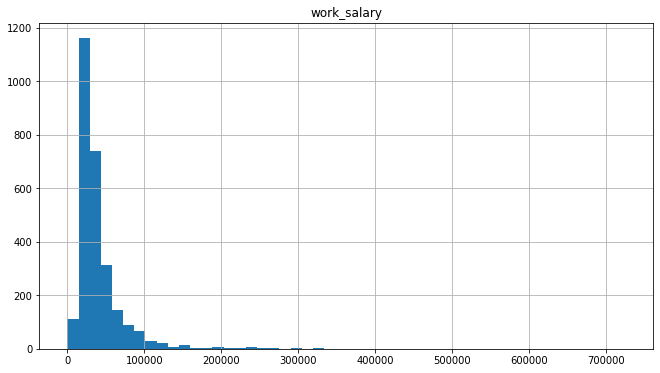

In [ ]:
# data = data_backup.copy()
data.hist('work_salary', figsize=(11,6), bins=50)

In [ ]:
lower_limit = data['work_salary'].quantile(0.01)
upper_limit = data['work_salary'].quantile(0.99)
median = data.loc[(data['work_salary'] >lower_limit)|(data['work_salary'] <upper_limit), 'work_salary'].median()
print(lower_limit,upper_limit,median)

9601.9 207289.33999999872 30000.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd423d75c88>]],
      dtype=object)

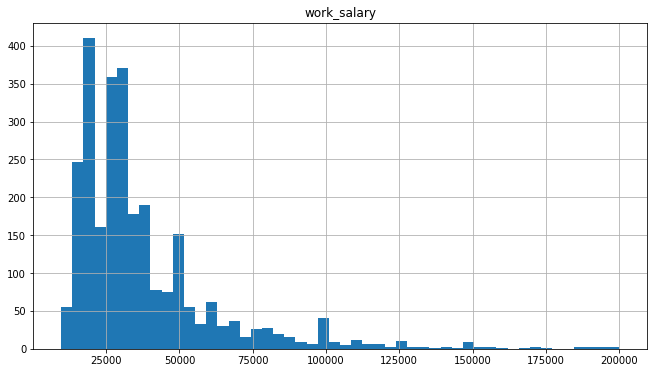

In [ ]:
data['work_salary'] = np.where((data['work_salary'] <lower_limit)|(data['work_salary'] >upper_limit), median,data['work_salary'])
data.hist('work_salary', figsize=(11,6), bins=50)

In [ ]:
def histogram_without_anamoly(feature, bin_size):
    lower_limit = data[feature].quantile(0.02)
    upper_limit = data[feature].quantile(0.98)
    median = data.loc[(data[feature] >lower_limit)|(data[feature] <upper_limit), feature].median()
    print(lower_limit,upper_limit,median)
    data[feature] = np.where((data[feature] <lower_limit)|(data[feature] >upper_limit), median,data[feature])
    data.hist(feature, figsize=(11,6), bins=bin_size)

0.0 312.0 60.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


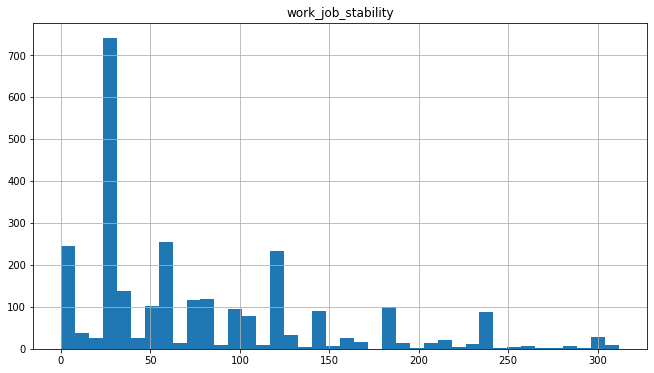

In [ ]:
histogram_without_anamoly('work_job_stability', 40)

0


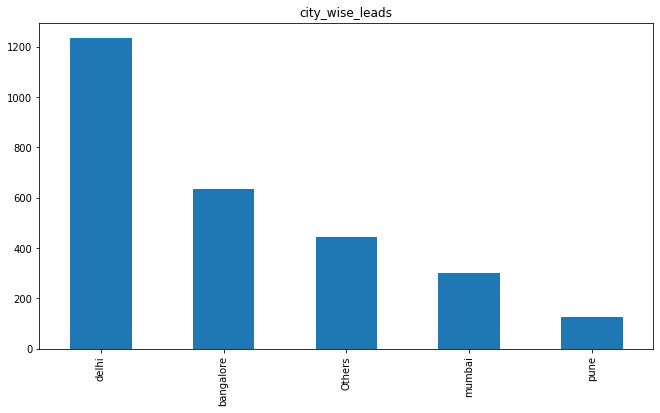

In [ ]:
print((data['city_wise_leads'].isnull()).sum())
data['city_wise_leads'].value_counts().plot(kind ='bar', figsize=(11,6), title="city_wise_leads")

0


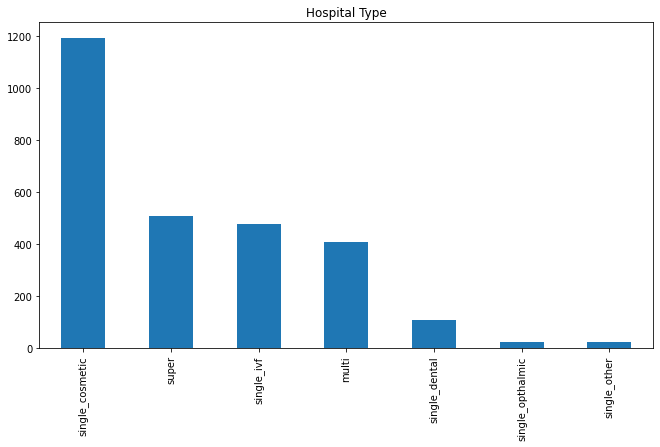

In [ ]:
print((data['hospitalObject_type'].isnull()).sum())
data['hospitalObject_type'].value_counts().plot(kind ='bar', figsize=(11,6), title="Hospital Type")

22.0 54.0 31.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


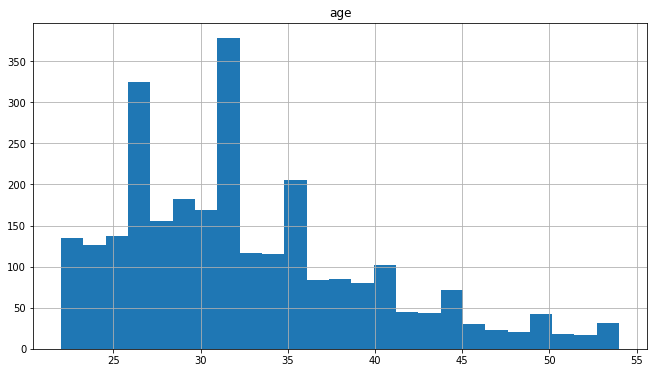

In [ ]:
histogram_without_anamoly('age', 25)

0


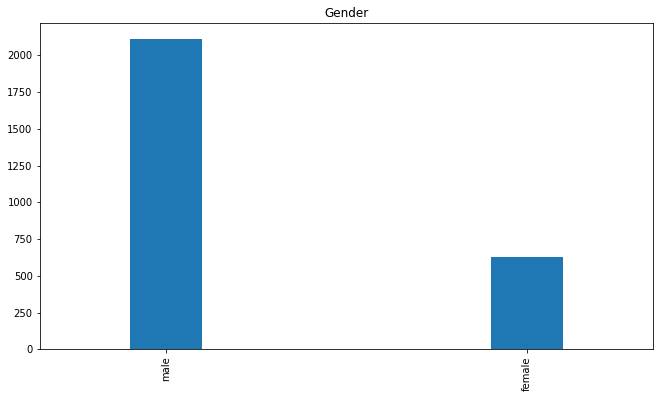

In [ ]:
print((data['gender'].isnull()).sum())
data['gender'].value_counts().plot(kind ='bar', figsize=(11,6), title="Gender", width=0.2)

2353


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


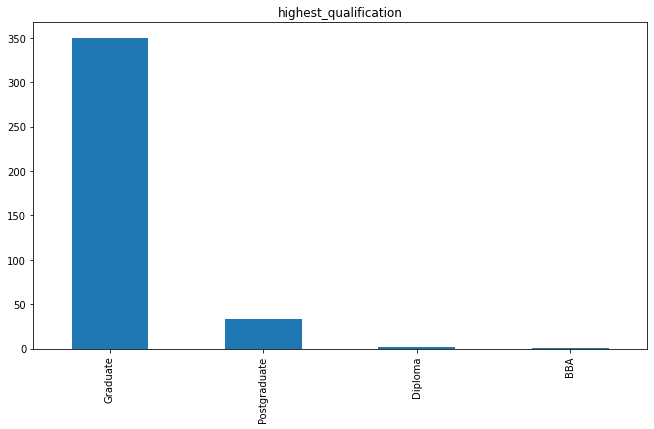

In [ ]:
print((data['highest_qualification'].isnull()).sum())
data['highest_qualification'].value_counts().plot(kind ='bar', figsize=(11,6), title="highest_qualification")
data.drop(['highest_qualification'], axis=1, inplace= True)


5


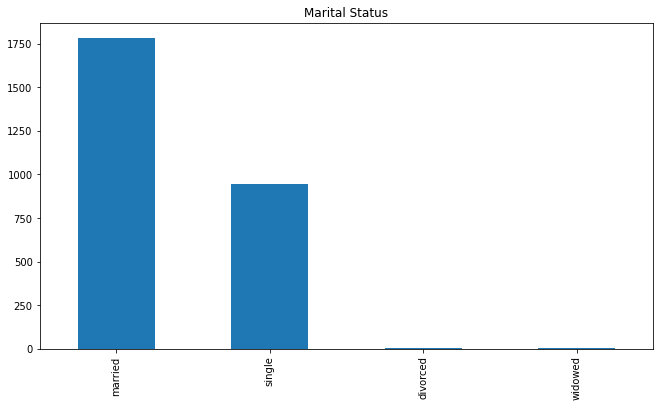

In [ ]:
#birth_place	type	business_type	business_type_n	company_category	cc_n	current_job_duration	cj_n	designation	designation_n	employment_type
print((data['marital_status'].isnull()).sum())
data['marital_status'].value_counts().plot(kind ='bar', figsize=(11,6), title="Marital Status")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


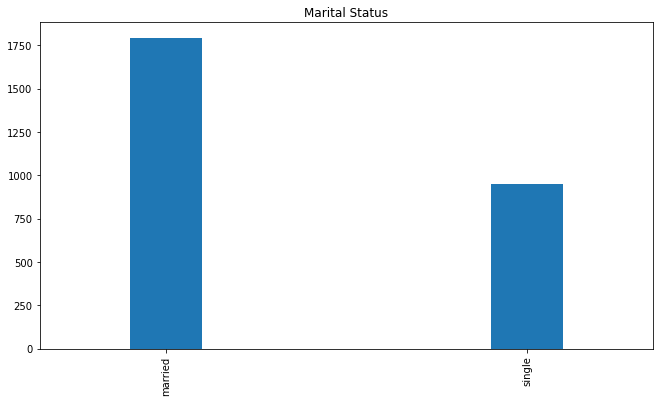

In [ ]:
data['marital_status'] = np.where((data['marital_status'].isin(['widowed','divorced']))|(data['marital_status'].isnull()), 'married',data['marital_status'])
data['marital_status'].value_counts().plot(kind ='bar', figsize=(11,6), title="Marital Status", width=0.2)

0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


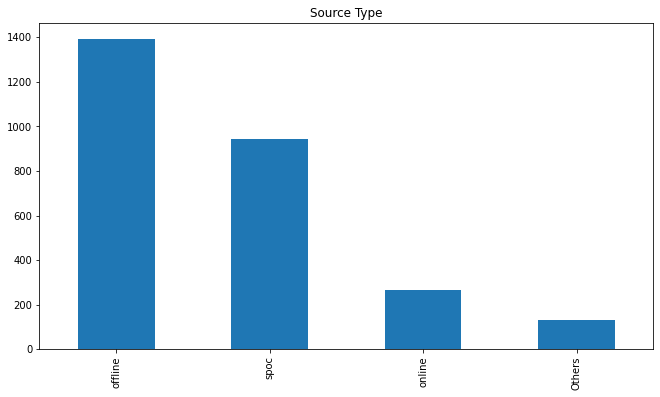

In [ ]:
# print((data['type'].isnull()).sum())
data.loc[~(data['type'].isin(['offline', 'spoc', 'online'])), 'type'] = 'Others'
data['type'].value_counts().plot(kind ='bar', figsize=(11,6), title="Source Type")

0


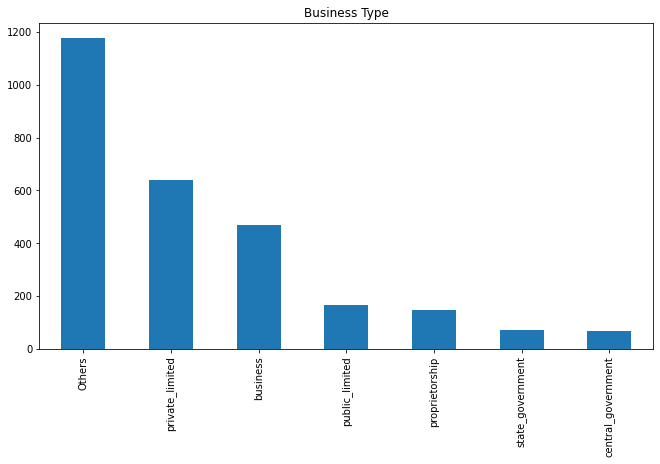

In [ ]:
print((data['work_business_type'].isnull()).sum())
data['work_business_type'].value_counts().plot(kind ='bar', figsize=(11,6), title="Business Type")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

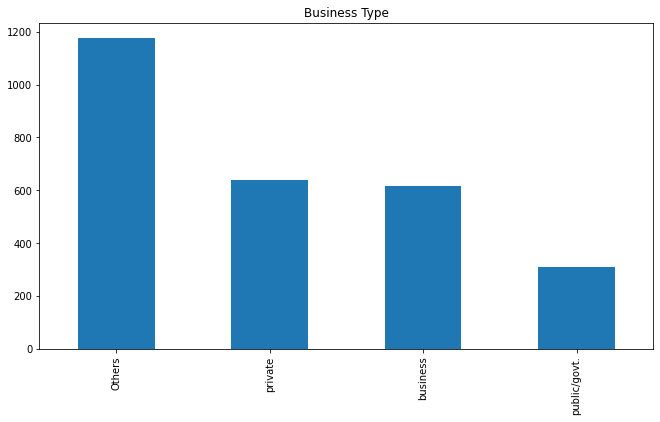

In [ ]:
data['work_business_type'] = np.where(data['work_business_type'].isin(['proprietorship','partnership','one_person_company']), 'business',data['work_business_type'])
data['work_business_type'] = np.where(data['work_business_type'].isin(['public_limited','central_government','state_government']), 'public/govt.',data['work_business_type'])
data['work_business_type'] = np.where(data['work_business_type'].isin(['private_limited','service_industry']), 'private',data['work_business_type'])

data['work_business_type'].value_counts().plot(kind ='bar', figsize=(11,6), title="Business Type")

In [ ]:
data['target'] = [1 if x in [1,2,3,4] else 0 for x in data['default']]
data['target1'] = [1 if x in [2,3,4] else 0 for x in data['default']]
data['target2'] = [1 if x in [4] else 0 for x in data['default']]

correlations = data.corr()['target'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 work_current_job_duration   -0.013054
age                         -0.009154
down_payment                -0.000705
advance_emi                  0.000079
processing_fee               0.012966
net_disbursal_amount         0.025057
loan_amount                  0.027972
actual_medical_bill          0.043176
foir                         0.062222
loan_tenure                  0.157505
loan_rate                    0.201637
target2                      0.676130
target1                      0.893203
default                      0.919423
target                       1.000000
Name: target, dtype: float64

Most Negative Correlations:
 work_salary                 -0.155645
dmi_cibil_score             -0.089413
abb_3_months                -0.074780
hospitalObject_status       -0.063154
proposed_emi                -0.049524
work_job_stability          -0.039727
subvention_percentage       -0.036188
existing_emi                -0.031969
work_current_job_duration   -0.013054


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

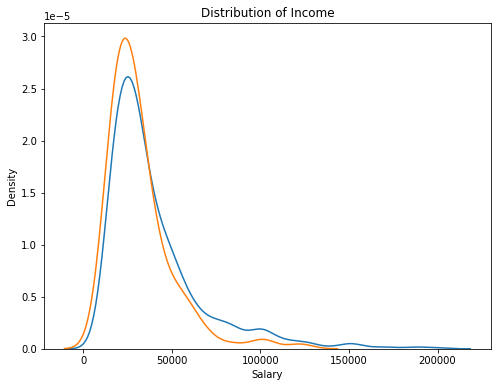

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['default'] == 0, 'work_salary'], label = 'default = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['default'] == 1, 'work_salary'], label = 'default = 1')

# Labeling of plot
plt.xlabel('Salary'); plt.ylabel('Density'); plt.title('Distribution of Income');

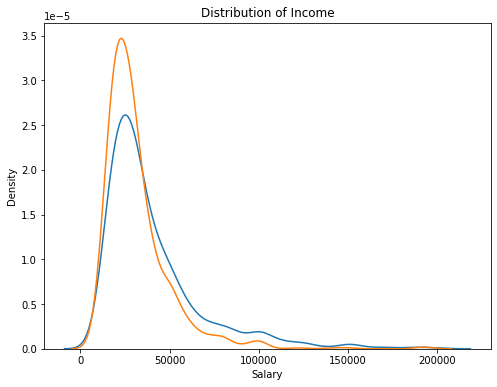

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['target'] == 0, 'work_salary'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['target'] == 1, 'work_salary'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Salary'); plt.ylabel('Density'); plt.title('Distribution of Income');

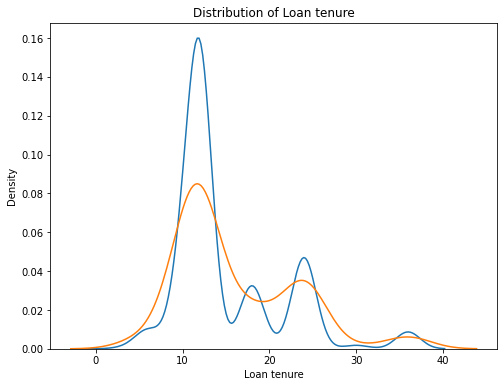

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['default'] == 0, 'loan_tenure'], label = 'default = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['default'] == 1, 'loan_tenure'], label = 'default = 1')

# Labeling of plot
plt.xlabel('Loan tenure'); plt.ylabel('Density'); plt.title('Distribution of Loan tenure');

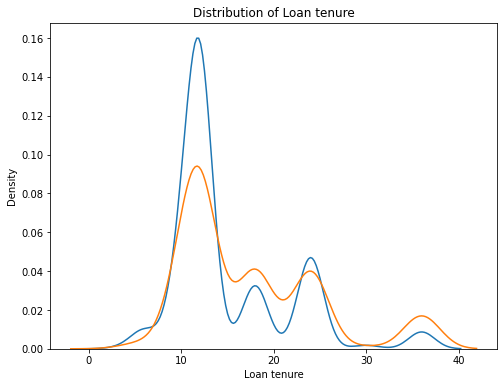

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['target'] == 0, 'loan_tenure'], label = 'target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['target'] == 1, 'loan_tenure'], label = 'target = 1')

# Labeling of plot
plt.xlabel('Loan tenure'); plt.ylabel('Density'); plt.title('Distribution of Loan tenure');

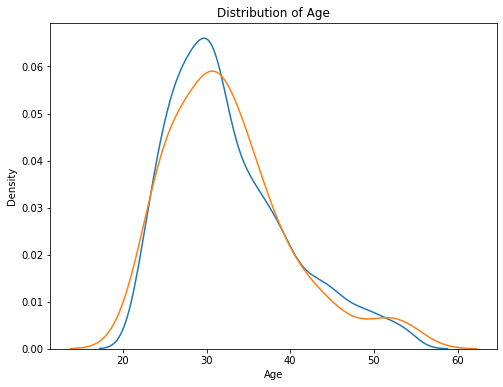

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['default'] == 0, 'age'], label = 'default == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['default'] == 1, 'age'], label = 'default == 1')

# Labeling of plot
plt.xlabel('Age'); plt.ylabel('Density'); plt.title('Distribution of Age');

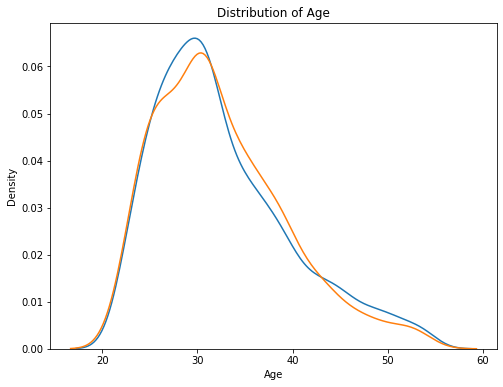

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['target'] == 0, 'age'], label = 'default == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['target'] == 1, 'age'], label = 'default == 1')

# Labeling of plot
plt.xlabel('Age'); plt.ylabel('Density'); plt.title('Distribution of Age');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


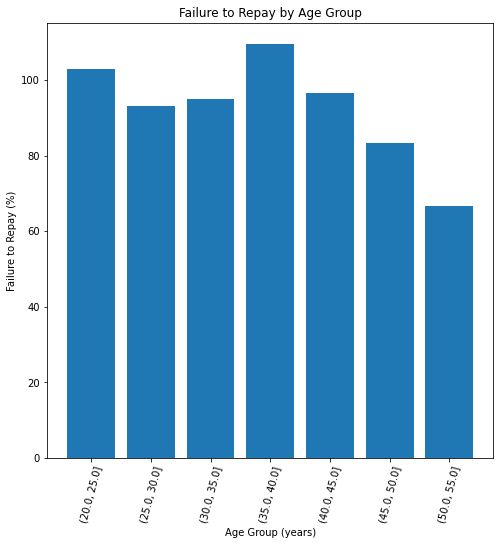

In [ ]:
# Age information into a separate dataframe
age_data = data[['default', 'age']]
age_data['YEARS_BIRTH'] = data['age']

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['default'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


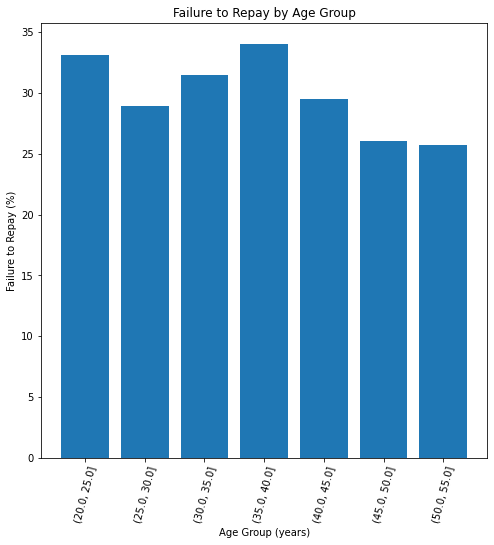

In [ ]:
# Age information into a separate dataframe
age_data = data[['target', 'age']]
age_data['YEARS_BIRTH'] = data['age']

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['target'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

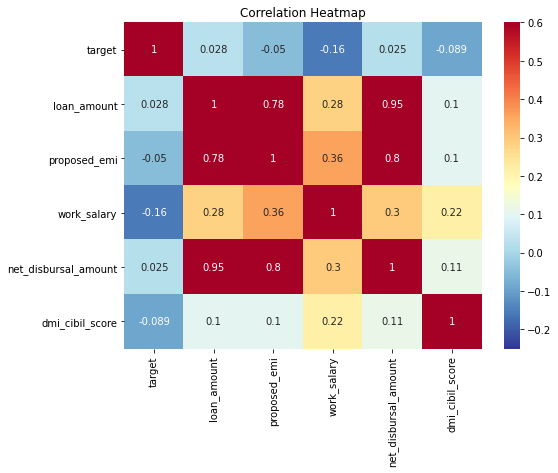

In [ ]:
ext_data = data[['target', 'loan_amount', 'proposed_emi', 'work_salary', 'net_disbursal_amount','dmi_cibil_score']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserW

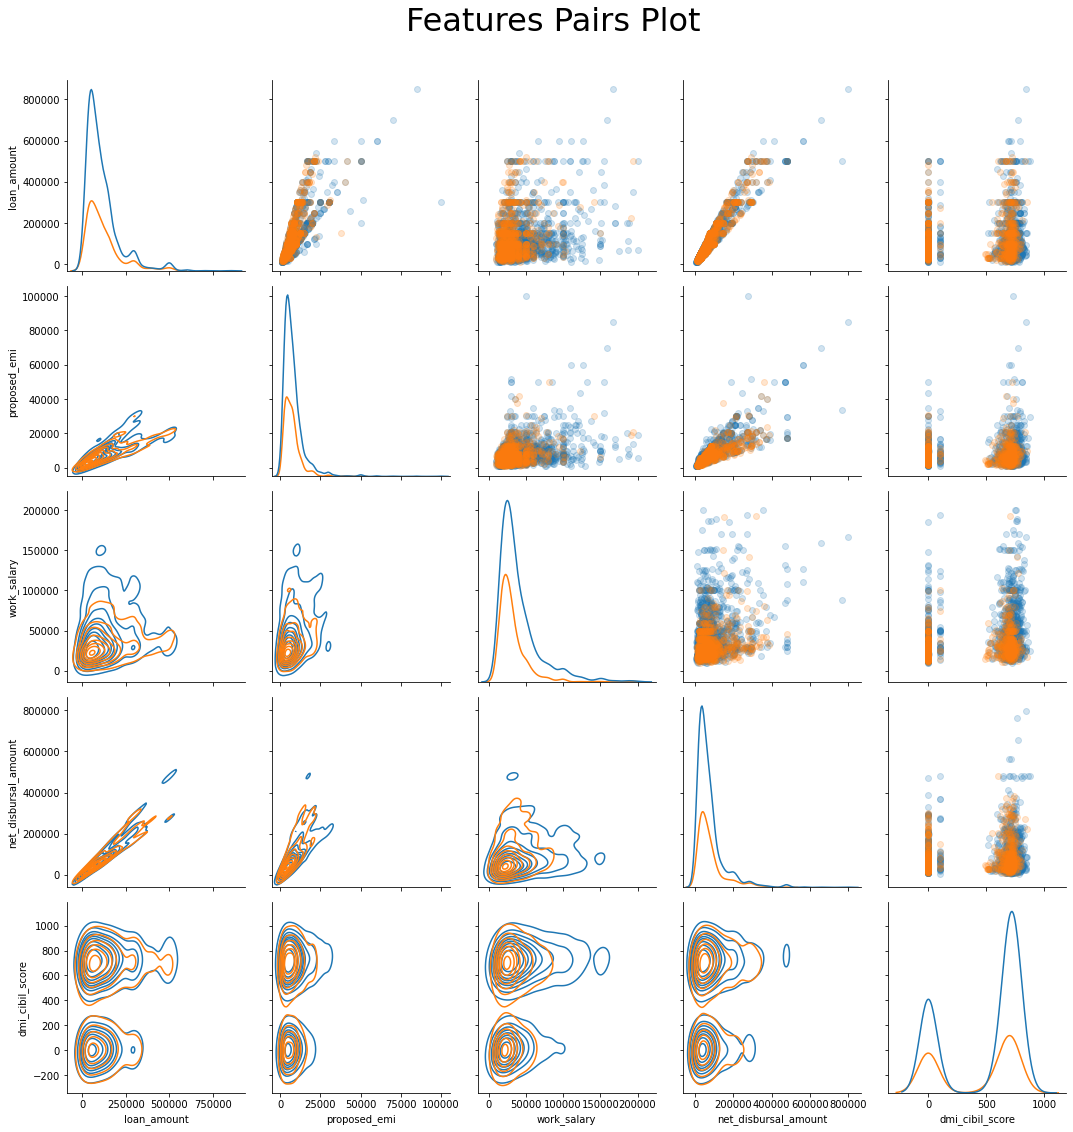

In [ ]:
plot_data = ext_data.copy()

# # Add in the age of the client in years
# plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# # Drop na values and limit to first 100000 rows
# plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'target', 
                    vars = [x for x in list(plot_data.columns) if x != 'target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Features Pairs Plot', size = 32, y = 1.05);

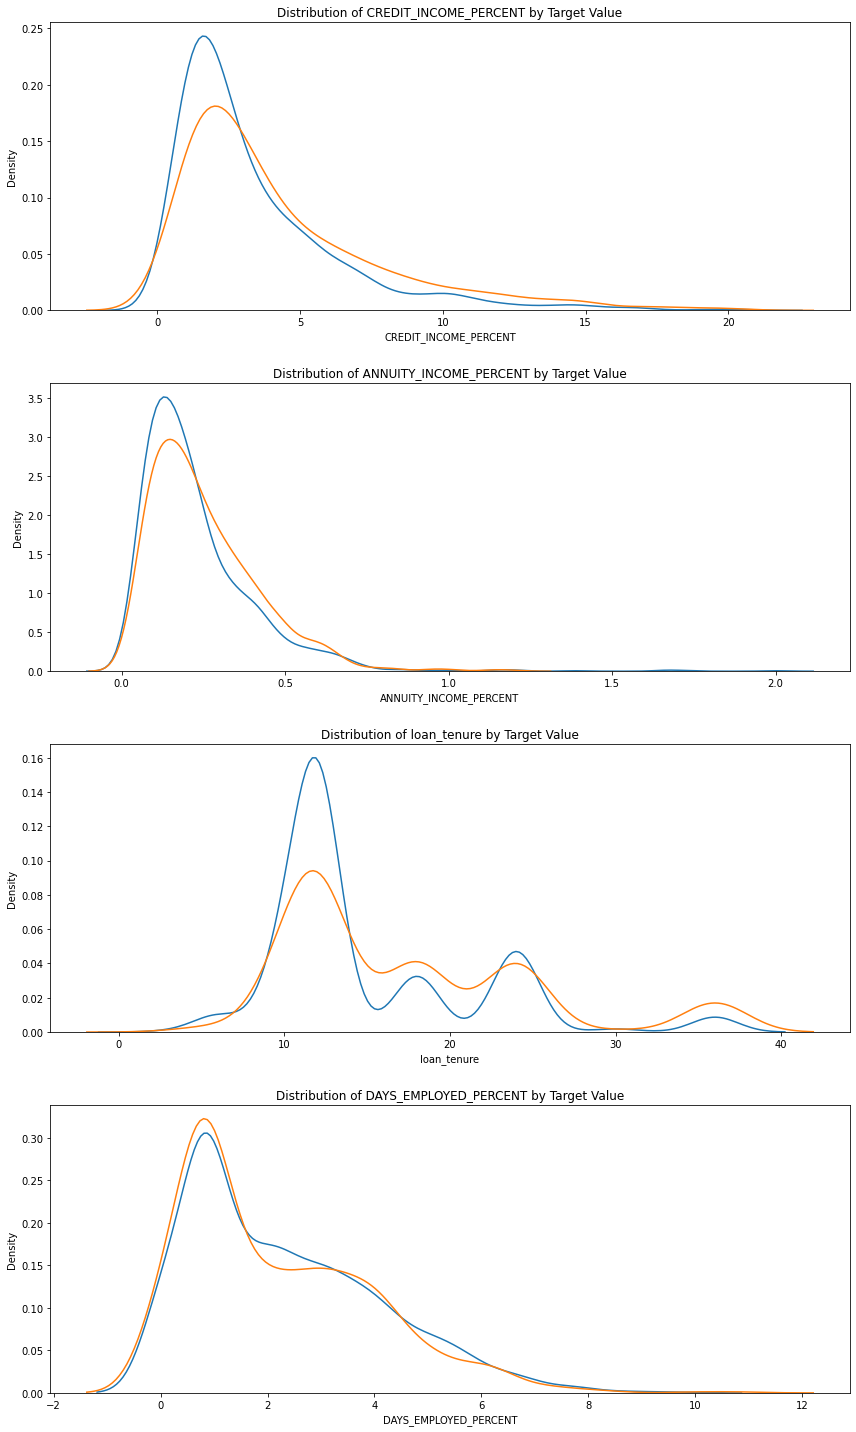

In [ ]:
data_train = data.copy()
data_test = data.copy()
data_train_domain = data_train.copy()
data_test_domain = data_test.copy()

data_train_domain['CREDIT_INCOME_PERCENT'] = data_train_domain['loan_amount'] / data_train_domain['work_salary']
data_train_domain['ANNUITY_INCOME_PERCENT'] = data_train_domain['proposed_emi'] / data_train_domain['work_salary']
data_train_domain['DAYS_EMPLOYED_PERCENT'] = data_train_domain['work_job_stability'] / data_train_domain['age']

# data_test_domain['CREDIT_INCOME_PERCENT'] = data_test_domain['AMT_CREDIT'] / data_test_domain['AMT_INCOME_TOTAL']
# data_test_domain['ANNUITY_INCOME_PERCENT'] = data_test_domain['AMT_ANNUITY'] / data_test_domain['AMT_INCOME_TOTAL']
# data_test_domain['CREDIT_TERM'] = data_test_domain['AMT_ANNUITY'] / data_test_domain['AMT_CREDIT']
# data_test_domain['DAYS_EMPLOYED_PERCENT'] = data_test_domain['DAYS_EMPLOYED'] / data_test_domain['DAYS_BIRTH']

plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'loan_tenure', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data_train_domain.loc[data_train_domain['target'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data_train_domain.loc[data_train_domain['target'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
data_train.head()

,bucket,dmi_credit_decision,dmi_cibil_score,lender,type,loan_amount,loan_tenure,loan_rate,subvention_percentage,processing_fee,down_payment,net_disbursal_amount,loan_purpose,loan_to_be_disbursed,proposed_emi,advance_emi,surgery_id,borrower_relationship,loan_type,work_job_stability,work_business_type,work_salary,work_employment_type,hospitalObject_type,default,existing_emi,foir,abb_3_months,existing_loan_1,gender,work_company_category,work_current_job_duration,marital_status,actual_medical_bill,hospitalObject_nature,hospitalObject_status,city_wise_leads,address_city,age,target,target1,target2
lead_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30671,hot,REJECT,697.0,liquiloan10,offline,120000,12,0.0,6.5,2832.0,30000.0,79368.0,medical,hospital,10000.00,3.0,IVF,Husband,FLDG,122.0,private,78084.0,Salaried,single_ivf,0,34767.0,12.81,14512.89,Housing Loan,male,private_limited,116.0,married,120000.0,chain,1.0,delhi,Others,36.0,0,0,0
29603,hot,Pre Approved,696.0,liquiloan10,offline,65000,12,0.0,6.5,1534.0,16251.0,42990.0,medical,hospital,5417.00,3.0,IVF,Others,FLDG,12.0,business,111982.0,SENP,single_ivf,0,0.0,4.84,167973.56,Others,male,proprietorship,12.0,married,65000.0,standalone,1.0,delhi,Others,43.0,0,0,0
29302,hot,Reject,0.0,stashFin,offline,50000,12,0.0,6.5,1180.0,12500.0,33070.0,medical,hospital,4167.00,3.0,Others,Others,FLDG,120.0,Others,26186.0,Salaried,single_cosmetic,0,3079.0,16.03,13366.56,Others,male,Others,71.0,single,50000.0,standalone,1.0,delhi,Delhi,27.0,0,0,0
32478,hot,Reject,NaN,liquiloan10,offline,100000,12,0.0,6.5,2360.0,25000.0,66140.0,medical,hospital,8333.33,3.0,Others,Others,FLDG,60.0,private,86522.0,Salaried,single_cosmetic,0,10356.0,11.90,190.78,Personal Loan,male,private_limited,60.0,single,100000.0,chain,1.0,bangalore,Bengaluru,29.0,0,0,0
32303,hot,Pre Approved,730.0,liquiloan10,offline,300000,10,0.0,6.0,7080.0,60000.0,282000.0,medical,hospital,30000.00,2.0,Others,Others,FLDG,300.0,business,25000.0,SENP,super,0,0.0,120.00,76509.33,Others,female,business,300.0,single,300000.0,chain,1.0,delhi,Ghaziabad,44.0,0,0,0


In [ ]:
# data_train['loan_to_be_disbursed'].value_counts()
data_train['dmi_cibil_score'].fillna(700, inplace = True)
data_train.fillna("NA", inplace = True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data_train:
    if data_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data_train[col].unique())) <= 7:
            # Train on the training data
            print(col)
            le.fit(data_train[col])
            # Transform both training and testing data
            data_train[col] = le.transform(data_train[col])
            # data_test[col] = le.transform(data_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

bucket
dmi_credit_decision
lender
type
loan_purpose
loan_to_be_disbursed
surgery_id
borrower_relationship
loan_type
work_business_type
work_employment_type
hospitalObject_type
existing_loan_1
gender
work_company_category
marital_status
hospitalObject_nature
city_wise_leads
address_city
19 columns were label encoded.


In [ ]:
# data_train = data_train[['hospitalObject_type','work_employment_type','dmi_credit_decision','lender','advance_emi','age', 'work_current_job_duration','work_job_stability','work_salary','dmi_cibil_score', 'loan_amount','loan_tenure','loan_rate','proposed_emi']]
data_train.drop(['default', 'target1', 'target2'], axis = 1, inplace = True)
data_test = data_train.copy()
train_labels = data[['target']]

In [ ]:
data_train.head()

,bucket,dmi_credit_decision,dmi_cibil_score,lender,type,loan_amount,loan_tenure,loan_rate,subvention_percentage,processing_fee,down_payment,net_disbursal_amount,loan_purpose,loan_to_be_disbursed,proposed_emi,advance_emi,surgery_id,borrower_relationship,loan_type,work_job_stability,work_business_type,work_salary,work_employment_type,hospitalObject_type,existing_emi,foir,abb_3_months,existing_loan_1,gender,work_company_category,work_current_job_duration,marital_status,actual_medical_bill,hospitalObject_nature,hospitalObject_status,city_wise_leads,address_city,age,target
lead_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30671,1,2,697.0,2,1,120000,12,0.0,6.5,2832.0,30000.0,79368.0,1,2,10000.00,3.0,1,0,1,122.0,2,78084.0,3,3,34767.0,12.81,14512.89,2,1,3,116.0,0,120000.0,0,1.0,2,4,36.0,0
29603,1,1,696.0,2,1,65000,12,0.0,6.5,1534.0,16251.0,42990.0,1,2,5417.00,3.0,1,1,1,12.0,1,111982.0,1,3,0.0,4.84,167973.56,3,1,4,12.0,0,65000.0,1,1.0,2,4,43.0,0
29302,1,3,0.0,4,1,50000,12,0.0,6.5,1180.0,12500.0,33070.0,1,2,4167.00,3.0,2,1,1,120.0,0,26186.0,3,1,3079.0,16.03,13366.56,3,1,0,71.0,1,50000.0,1,1.0,2,1,27.0,0
32478,1,3,700.0,2,1,100000,12,0.0,6.5,2360.0,25000.0,66140.0,1,2,8333.33,3.0,2,1,1,60.0,2,86522.0,3,1,10356.0,11.90,190.78,4,1,3,60.0,1,100000.0,0,1.0,1,0,29.0,0
32303,1,1,730.0,2,1,300000,10,0.0,6.0,7080.0,60000.0,282000.0,1,2,30000.00,2.0,2,1,1,300.0,1,25000.0,1,6,0.0,120.00,76509.33,3,0,1,300.0,1,300000.0,0,1.0,2,2,44.0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'target' in data_train:
    train = data_train.drop(columns = ['target'])
else:
    train = data_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
# test = data_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'most_frequent')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
# test = imputer.transform(data_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
# test = scaler.transform(test)

print('Training data shape: ', train.shape)
# print('Testing data shape: ', test.shape)

Training data shape:  (2739, 38)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(train)[:, 1]

# Submission dataframe
submit = data[['target']]
submit['predicted'] = log_reg_pred

submit.head()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,target,predicted
lead_id,,
30671,0,0.306768
29603,0,0.308238
29302,0,0.310052
32478,0,0.306748
32303,0,0.306762


In [ ]:
submit['target'].corr(submit['predicted'])

0.3156781606238729

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(submit['target'], submit['predicted'])

0.69422717644633